In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from soak_low_level import SOAK

In [2]:
# dataset info
dataset = 'WorkersCompensation'
target_col = 'UltimateIncurredClaimCost'
subset_col = 'Gender'

# Load data
data = np.genfromtxt(f'data/{dataset}.csv.xz', delimiter=',', dtype=None, names=True, encoding=None)
X = np.column_stack([data[name] for name in data.dtype.names if name.startswith('X_')])
y = data[target_col]
subset_vec = data[subset_col]

In [3]:
# initial soak obj
soak_obj = SOAK(n_splits=5)

In [4]:
# list of models
model_list = ['featureless', 'linear', 'linear_BasExp', 'tree', 'mlp']

In [5]:
# store results
results = []

In [6]:
# full size
for subset_value, category, X_train, y_train, X_test, y_test in soak_obj.split(X, y, subset_vec):
    for model in model_list:
        mse, mae = soak_obj.model_eval(X_train, y_train, X_test, y_test, model)
        results.append({
                    "subset": subset_value,
                    "category": category,
                    "model": model,
                    "mse": mse,
                    "mae": mae,
                    "train_size": len(y_train),
                    "test_size": len(y_test),
                    "downsample": False
                })

In [7]:
# downsampled
n_seeds = 3
for _ in range(n_seeds):
    for subset_value, category, X_train, y_train, X_test, y_test in soak_obj.split(X, y, subset_vec):
        n = int(min(((soak_obj.n_splits - 1)/soak_obj.n_splits) * np.sum(subset_vec == subset_value), np.sum(subset_vec != subset_value)))
        idx = np.random.choice(len(y_train), size=n, replace=False)
        for model in model_list:
            mse, mae = soak_obj.model_eval(X_train[idx], y_train[idx], X_test, y_test, model)
            results.append({
                        "subset": subset_value,
                        "category": category,
                        "model": model,
                        "mse": mse,
                        "mae": mae,
                        "train_size": len(idx),
                        "test_size": len(y_test),
                        "downsample": True
                    })

In [8]:
results_df = pd.DataFrame(results)

In [9]:
def plot_metrics(results_df, subset_value, metric='mse', plot_size=1):
    _, counts = np.unique(results_df['downsample'], return_counts=True)
    df = results_df[results_df['subset'] == subset_value].copy()
    df.loc[:, f'log_{metric}'] = np.log10(df[metric])
    df = df.groupby(['subset', 'category', 'model', 'downsample']).agg(
        avg=(f'log_{metric}', 'mean'),
        sd=(f'log_{metric}', lambda x: x.std(ddof=0)),
        test_size=('test_size', 'min'),
        train_size=('train_size', 'min'),
    ).reset_index()
    models = df['model'].unique()
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(plot_size*7, plot_size*1.8*len(models)), sharex=True)
    for i, category in enumerate(['all', 'same', 'other']):
        ax = axes[i]
        ax.grid(alpha = 0.2)
        ax.set_ylim(-0.5, 2*len(models) + len(models) - 1 - 0.5)
        ax.set_ylabel(category, rotation=0, labelpad=20, va='center', fontweight='bold')
        ax.yaxis.set_label_position("right")
        ax.set_yticks(range(2*len(models) + len(models) - 1))
        model_infos = []
        for j, model in enumerate(models):
            for k, downsample in enumerate(df['downsample'].unique()):
                data = df[(df['category'] == category) & (df['model'] == model) & (df['downsample'] == downsample)]
                ax.errorbar(data['avg'].item(), 3*j+k, xerr=data['sd'].item(), fmt='o', 
                            label = ('reduced' if data['downsample'].item() else 'full') if j == 0 else None, 
                            color='red' if data['downsample'].item() else 'black')
                model_infos.append(f"{model}.{data['train_size'].item()}")
            ax.axhline(y=(3*j + 2), color='gray', linestyle='-', linewidth=1)
            model_infos.append("")
        ax.set_yticklabels([f"{m}" for m in model_infos[:-1]])
    ax.set_xlabel(f'log({metric.upper()})')
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles[::-1], labels[::-1], loc='upper right', fontsize=9)
    fig.suptitle(f"Subset: {subset_value} | test size = {df['test_size'].max()} | "
                 f"{results_df[results_df['downsample'] == False].groupby(['subset', 'category', 'model']).size().reset_index(name='count')['count'].min()} test folds | "
                 f"{int(counts.max()/counts.min())} random seeds", 
                 fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()

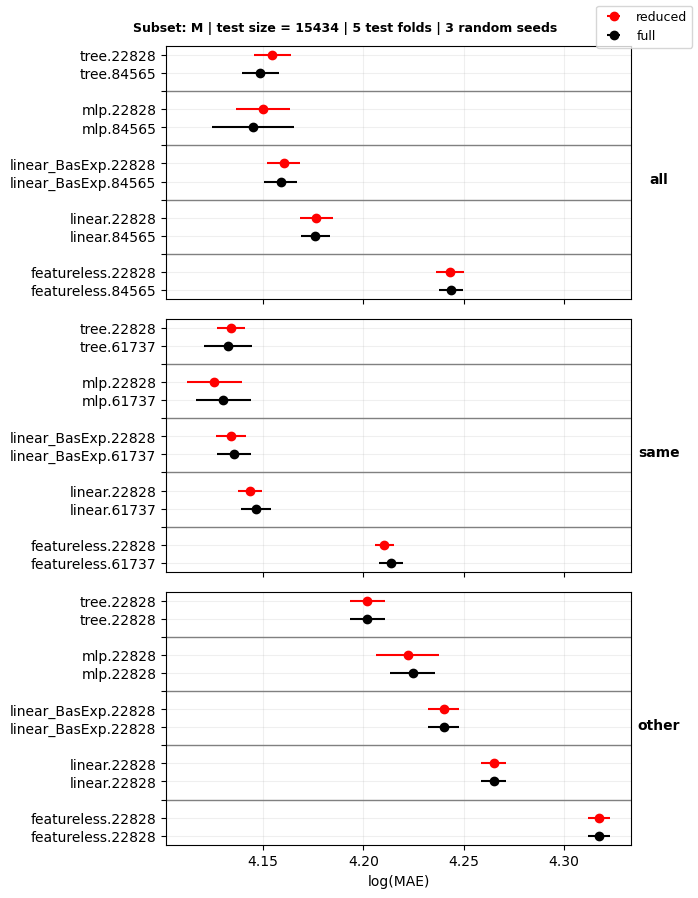

In [10]:
plot_metrics(results_df, 'M', 'mae')

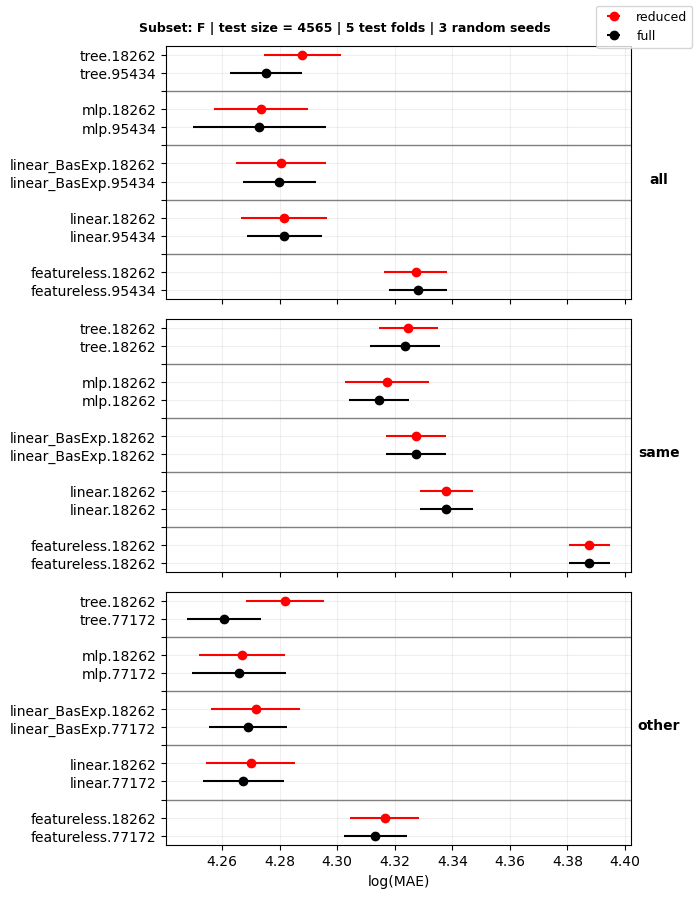

In [11]:
plot_metrics(results_df, 'F', 'mae')

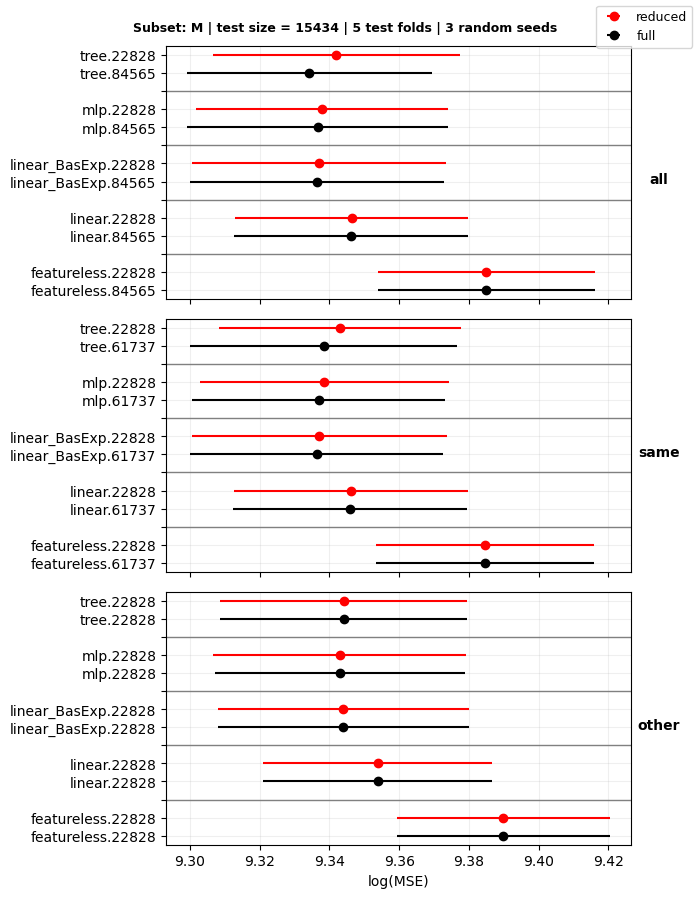

In [13]:
plot_metrics(results_df, 'M', 'mse')

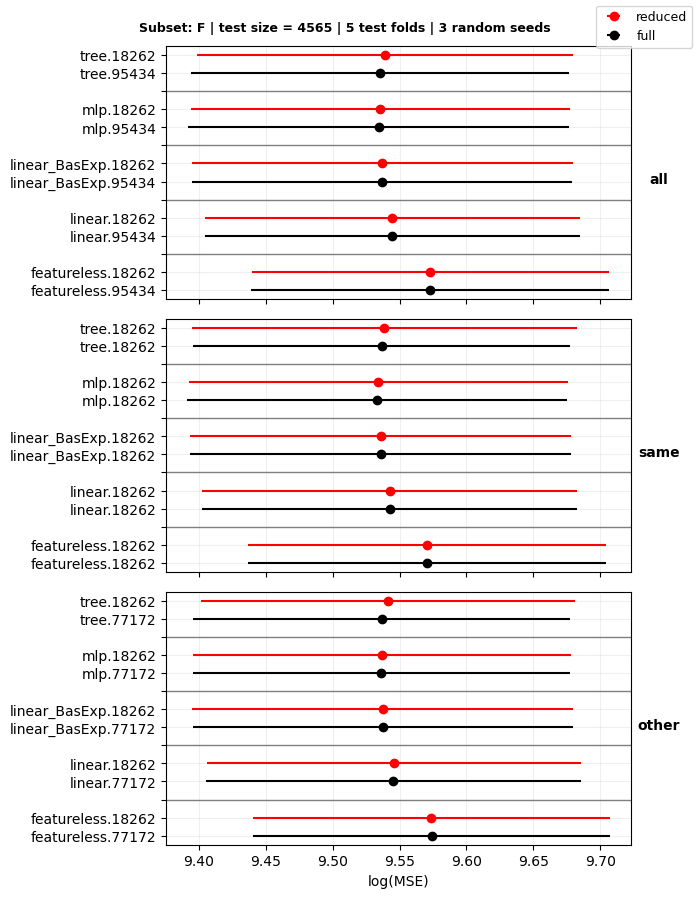

In [14]:
plot_metrics(results_df, 'F', 'mse')